# Jupyterでデータセット作成アプリを作る

# これなに

Fringe81で機械学習エンジニアをやっている長谷川です。5日目の記事では、Jupyterを使用したデータセットを作るための簡単なアプリケーション作成方法について書きます。  

## 実行例

TODO 

# 機械学習をする際に一番つらいところ。データセットの教師ラベルづけ

機械学習をする上で、ある意味アルゴリズム以上に辛いのは、データセットの作成です。教師あり学習の場合、当然教師ラベルを付与する必要があるのですが、そんな都合よくラベルが付いているデータがあることは少なく、仮についていたとしても人力での補正が必要な場合は多々あります。
**そこで、人力でのラベル付をJupyter上で完結する形でできたら非常に便利です。**


# Jupyterとは?

さまざまなコードのインタラクティブな実行などが可能になる、ブラウザベースのエディタです。この記事もすべてJupyter上で書きました。  
pythonのイメージが強いですが、kernelさえ入れ替えれば大抵の言語は実行可能です。(ちなみにJupyterの名前の由来はJulia+python+Rだそうです。)  
さらに、juypterには**マジックコマンド**と呼ばれる機能があり、セルの先頭に*%%xxx*のようなアノテーションを付けると、シェルやsqlなど、さまざまな処理が実行可能になります。  
そのマジックコマンドを利用し、pythonのコードと**%%javascriptと%%htmlを組み合わせることにより、簡易的なラベルで付けアプリを作成してみます。**

# ライブラリのバージョン

TODO

# 実行例:twitterの検索結果のうち、Botのものをを判別する
例として、twitterからデータを取得し、twitterのAPIから取得したデータのうち、Botかどうかのラベル付けを行います。  
なお、以下のコードは[Real World DataScience]()を参考にしました。

## Tokenのロード
まず、別ファイルに記述してあるTokenを読み込みます。  
機密情報をJupyeにべた書きすると、予期せぬところで流出するリスクが極めて高いので、別ファイルに書き出しておいて読み込んだほうが良いです。

```
# twitter.json
{
"consumer_key":"xxx",
"consumer_secret":"xxx",
"token":"xxx",
"token_secret":"xxx"
}
```

In [2]:
import twitter
import json 

# confidentailな情報をうっかりgitにあげないように、別ファイルに保存してあるものを取得
with open('./twitter.json','r') as file: 
    token=json.load(file)
authorization = twitter.OAuth(**token)

# twitterとのI/Fのためのオブジェクト
t=twitter.Twitter(auth=authorization)

## APIを叩く
データを取得するためのメソッドです。twitterが存在するもののみを返します。

In [3]:
tweets=[] # tweetを格納していくlist

def  twitter_gen(search_word,count=100):
    search_results=t.search.tweets(q=search_word,count=count)['statuses']
    index=0
    
    while True:
        search_result=search_results[index]
        if 'text' in search_result:
            tweet=search_result['text']
            tweets.append(tweet)           
            yield tweet
        index+=1 


In [4]:

tweet_qiitas=twitter_gen('Qiita')

def get_next_tweet():
    return next(tweet_qiitas)

In [5]:
print(next(tweet_qiitas))

RT @1984sakurai: 数値計算 Advent Calendar 2018 2日目の記事を書きました
逆行列補題(Sherman Morrison Woodburyの公式)を利用してBFGS(H公式)を導出するというテーマになっています
https://t.co/d0…


取得できました。

## アプリケーションの動きをJSで実装
アプリケーション上で実行するために、**マジックコマンドを利用して、avascriptでscriptを記述します。**  
そして、**JSからJupyterのkernelに処理を送る**ことで、バックグラウンドでpythonを実行し、データを読み込みます。

In [6]:
# 正解ラベルを格納するlist
labels=[]

まず、ユーザーから判定されたラベルを追加していく処理です。  
Jupyterには`Python.notebook.kernel`を使用することで、処理が送信できます。  
このオブジェクトの`execute`メソッドにより、JSからpythonのスクリプトを実行できます。

In [7]:
%%javascript

function set_label(label){
    var kernel = IPython.notebook.kernel;
    kernel.execute("labels.append(" + label + ")");
    load_next_tweet();
}


<IPython.core.display.Javascript object>

TODO

In [8]:
%%javascript
function load_next_tweet(){
   var code_input = "get_next_tweet()";
   var kernel = IPython.notebook.kernel;
   var callbacks = { 'iopub' : {'output' : handle_output}};
   kernel.execute(code_input, callbacks, {silent:false});
}

<IPython.core.display.Javascript object>

In [9]:
%%javascript

function handle_output(out){
   var res = out.content.data["text/plain"];
   $("div#tweet_text").html(res);
}

<IPython.core.display.Javascript object>

TODO

In [10]:
%%html
<div name="tweetbox">
    Instructions: Click in textbox. Enter a 1 if the tweet is relevant, enter 0 otherwise.<br>
Tweet: 
    <div id="tweet_text" value="text"></div><br>
<input type=text id="capture"></input><br>
</div>



<script>
$("input#capture").keypress(function(e) {
if(e.which == 48) {
    set_label(0);
    $("input#capture").val("");
}else if (e.which==49){
    set_label(1);
    $("input#capture").val("");
  }
});


load_next_tweet();
</script>


## ラベルを確認

In [11]:
print(labels)
print(tweets)

[0, 1, 0, 1, 0, 1, 0, 0, 1]
['RT @1984sakurai: 数値計算 Advent Calendar 2018 2日目の記事を書きました\n逆行列補題(Sherman Morrison Woodburyの公式)を利用してBFGS(H公式)を導出するというテーマになっています\nhttps://t.co/d0…']


無事、入力したラベルが入っています。

## 保存してデータセットを作成
最後にデータセットをファイルに書き出しましょう。

In [5]:
import pandas as pd
pd.DataFrame(zip())

TypeError: data argument can't be an iterator

In [31]:
labels

[0, 0, 1, 0, 1, 0, 0, 0]

# 以下、過去の遺物

## 対処となるデータを読み込む
簡単のため、scikit-learnに組み込まれているMNISTを使用します。

In [67]:
import pandas as pd


import numpy as np

import matplotlib.pyplot as plt
%mataplotlib inline

UsageError: Line magic function `%mataplotlib` not found.


In [68]:
from sklearn.datasets import  load_digits
images=load_digits()['images']
# シャッフル
np.random.shuffle(images)

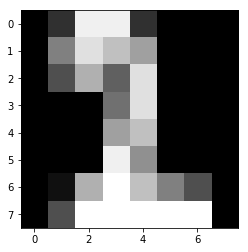

In [69]:
plt.imshow(images[3])
plt.gray()

これでラベル付けの対象となるデータはできました。ここから、実際にアプリケーション作成のためのコードを書いていきます。

## 裏側で実行されるpythonのコード

まず、

In [98]:
def image_gen(index=0):
    while True:
        yield images[index]
        index+=1

In [107]:
image_gen=image_gen

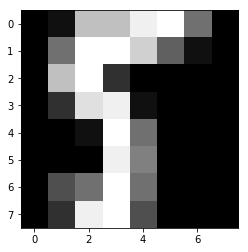

In [123]:
plt.imshow(next(image_gen))

## アプリケーションのインターフェースとして実行されるjavascript

In [ ]:
ここから、アプリケーションのインターフェースとしての動きを定義していきます。 マジックコマン*%%javascript%%により、 


In [114]:
%%javascript

function set_label(label){
    var kernel = IPython.notebook.kernel;
    kernel.execute("labels.append(" + label + ")");
    load_next_image();
}


<IPython.core.display.Javascript object>

In [115]:
%%javascript
function load_next_image(){
   var code_input = "next(image_gen)";
   var kernel = IPython.notebook.kernel;
   var callbacks = { 'iopub' : {'output' : handle_output}};
   kernel.execute(code_input, callbacks, {silent:false});
}

<IPython.core.display.Javascript object>

In [152]:
%%javascript

function handle_output(){
   var kernel = IPython.notebook.kernel;
   var callbacks = { 'iopub' : {'output' : handle_output}};
   kernel.execute("print(11111);aximshow(next(image_gen))");
}

<IPython.core.display.Javascript object>

In [153]:
%%html
<div name="imagebox">
    画像に一致すると思う数字を入力.<br>
画像 
    <div id="tweet_text" value="text"></div><br>
<input type=text id="capture"></input><br>
</div>



<script>
$("input#capture").keypress(function(e) {
   handle_output()
});


</script>


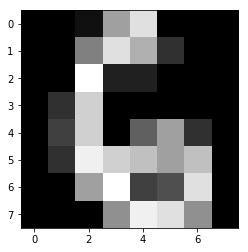

In [151]:
ax.imshow(next(image_gen))

In [122]:
%%html
<div name="imagebox">
    画像に一致すると思う数字を入力.<br>
画像 
    <div id="tweet_text" value="text"></div><br>
<input type=text id="capture"></input><br>
</div>



<script>
$("input#capture").keypress(function(e) {
    handle_output(e.which)
    $("input#capture").val("");
});

function set_label(label){
    var kernel = IPython.notebook.kernel;
    kernel.execute("labels.append(" + label + ")");
    load_next_tweet();
}


function load_next_tweet(){
   var code_input = "get_next_tweet()";
   var kernel = IPython.notebook.kernel;
   var callbacks = { 'iopub' : {'output' : handle_output}};
   kernel.execute(code_input, callbacks, {silent:false});
}

function handle_output(out){
    var res = out.content.data['text/plain']
   $("div#tweet_text").html(res);
}

load_next_tweet();
</script>


In [ ]:
# ラベルをファイルに保存
labels_file='./tweet_labels'

with open(labels_file,'w') as file:
    json.dump(labels,file)

In [ ]:
import twitter
import json 

# https://apps.twitter.com/app/13142176/show
# confidentailな情報をうっかりgitにあげないように、別ファイルに書き出し
with open('./twitter.json','r') as file: 
    token=json.load(file)
authorization = twitter.OAuth(**token)

# twitterとのI/Fのためのオブジェクト
t=twitter.Twitter(auth=authorization)

In [ ]:
# 検索データをファイルにアウトプット
output_file='./python_tweets.json'

with open(output_file,'a') as file:
    search_results=t.search.tweets(q='python',count=100)['statuses']
    
    for tweet in search_results:
        if 'text' in tweet:
            # オブジェクトをjsonに変換
            file.write(json.dumps(tweet))
            file.write('\n\n')